In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from pandas.plotting import parallel_coordinates
from scipy.special import expit, logit
from sklearn.decomposition import PCA
from sklearn.linear_model import HuberRegressor
from sklearn.metrics import mean_squared_error, median_absolute_error
from sklearn.model_selection import RepeatedKFold

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

In [2]:
#ToC

# Table of Contents

# Will the gap keep the same?

In a previous [kernel][1], I estimated the applicants gap in the schools of NYC in 2017. If you are not sure what I'm talking about, be sure to read the kernel (here, again).

After that, I came with the following question:

> Will the applicants gap measured in 2017 still be relevant in 2018?

That is... Does the information from 2017 help us choose which schools to act on 2018?

To try to answer this question, I will provide a model for predicting the applicants gap in District 5 (Central Harlem) in the year of 2013, 2014, 2015 and 2016.

This model will use a lot less data than the last one though (there are only 24 (?) relevant schools in central harlem). But, maybe, we can get to a conclusion that the applicants gap in a year does matter to the following year, or, better, *how* much does it matter.

[1]: kernel

# Data

![](../data/keep/map-harlem.png)

**TODO: summarize for joined data already**

- Made as a mix between the handed-out D5 dataset and a dataset available in the NYC website
- Comprehends 28 schools from Central Harlem
- From 2013 to 2016
- Grade 8
- *some schools have missing information*

In [3]:
df = pd.read_pickle('../data/process/d5_shsat.pkl')
df = df.reset_index()
print(df['DBN'].nunique(), "schools")

# drop entries with missing test results
df = df[df.notnull().any(axis=1)]
print(df['DBN'].nunique(), "schools after dropping missing Common Core entries")

# drop schools that were not present in all years of this dataset
counts_per_school = df.groupby('DBN').size()
df = df[df['DBN'].apply(lambda x: counts_per_school[x] == 4)]
print(df['DBN'].nunique(), "schools after dropping schools with missing years information")

# reset index
df = df.set_index(['DBN', 'Year'])

df.head()

24 schools
24 schools after dropping missing Common Core entries
18 schools after dropping schools with missing years information


Charter School?  Number Tested - ELA  Mean Scale Score - ELA  \
DBN    Year                                                                 
05M046 2013              0.0                 84.0               -1.117422   
       2014              0.0                 85.0               -1.628713   
       2015              0.0                 66.0               -1.380656   
       2016              0.0                 58.0               -1.103425   
05M123 2013              0.0                 55.0               -1.045237   

             # Level 1 - ELA  % Level 1 - ELA  # Level 2 - ELA  \
DBN    Year                                                      
05M046 2013             47.0         55.95238             29.0   
       2014             57.0         67.05882             22.0   
       2015             41.0         62.12121             16.0   
       2016             39.0         67.24138             14.0   
05M123 2013             30.0         54.54545             20.0   

             % Level 2 - ELA  # Level 3 - ELA  % Level 3 - ELA  \
DBN    Year                                                      
05M046 2013         0.345238              7.0         0.083333   
       2014         0.258823              6.0         0.070588   
       2015         0.242424              9.0         0.136364   
       2016         0.241379              2.0         0.034483   
05M123 2013         0.363636              5.0         0.090909   

             # Level 4 - ELA  % Level 4 - ELA  # Level 3+4 - ELA  \
DBN    Year                                                        
05M046 2013              1.0         0.011905                8.0   
       2014              0.0         0.000000                6.0   
       2015              0.0         0.000000                9.0   
       2016              3.0         0.051724                5.0   
05M123 2013              0.0         0.000000                5.0   

             % Level 3+4 - ELA  Number Tested - Math  Mean Scale Score - Math  \
DBN    Year                                                                     
05M046 2013           9.523810                  88.0                -0.744606   
       2014           7.058824                  87.0                -1.012577   
       2015          13.636360                  67.0                -0.977286   
       2016           8.620690                  58.0                -1.679011   
05M123 2013           9.090909                  61.0                -1.690491   

             # Level 1 - Math  % Level 1 - Math  # Level 2 - Math  \
DBN    Year                                                         
05M046 2013              50.0          56.81818              31.0   
       2014              56.0          64.36782              26.0   
       2015              39.0          58.20896              23.0   
       2016              48.0          82.75862              10.0   
05M123 2013              47.0          77.04918              11.0   

             % Level 2 - Math  # Level 3 - Math  % Level 3 - Math  \
DBN    Year                                                         
05M046 2013          0.352273               7.0          0.079545   
       2014          0.298851               5.0          0.057471   
       2015          0.343284               4.0          0.059701   
       2016          0.172414               0.0          0.000000   
05M123 2013          0.180328               3.0          0.049180   

             # Level 4 - Math  % Level 4 - Math  # Level 3+4 - Math  \
DBN    Year                                                           
05M046 2013               0.0          0.000000                 7.0   
       2014               0.0          0.000000                 5.0   
       2015               1.0          0.014925                 5.0   
       2016               0.0          0.000000                 0.0   
05M123 2013               0.0          0.000000                 3.0   

             % Level 3+4 - Math  Enr

# Cross-validation

The same cross-validation method used in the other kernel. Inputs variables, though, are only the state test results.

Also, we reduced the number of splits, because the data is small.

In [4]:
inputs = df[[
    'Mean Scale Score - ELA',
    '% Level 2 - ELA',
    '% Level 3 - ELA',
    '% Level 4 - ELA',
    'Mean Scale Score - Math',
    '% Level 2 - Math',
    '% Level 3 - Math',
    '% Level 4 - Math',
]]

outputs = logit(df['% SHSAT Testers'])

In [5]:
# cross-validation
cv_results = []
n_splits = 5
n_repeats = 50
for n_components in range(1, inputs.shape[1] + 1):
    mae_scores = []
    mse_scores = []
    
    x = PCA(n_components).fit_transform(inputs)
    x = pd.DataFrame(x, index=inputs.index, columns=["PC{}".format(i) for i in range(1, n_components + 1)])
    x['Constant'] = 1
    y = outputs.copy()
    

    cv = RepeatedKFold(n_splits, n_repeats, random_state=1)    
    for train, test in cv.split(x):
        x_train = x.iloc[train]
        x_test = x.iloc[test]
        y_train = y.iloc[train]
        y_test = y.iloc[test]
        
        model = sm.RLM(y_train, x_train, M=sm.robust.norms.HuberT())
        results = model.fit()
        predictions = model.predict(results.params, exog=x_test)
        mae = median_absolute_error(y_test, predictions)
        mse = mean_squared_error(y_test, predictions)
        mae_scores.append(mae)
        mse_scores.append(mse)
        
    mae_scores = np.array(mae_scores).reshape(n_repeats, n_splits).mean(axis=1)  # mean of each repeat
    mse_scores = np.array(mse_scores).reshape(n_repeats, n_splits).mean(axis=1)  # mean of each repeat
        
    mae_mean = np.mean(mae_scores)
    mae_std = np.std(mae_scores)
    mse_mean = np.mean(mse_scores)
    mse_std = np.std(mse_scores)
    
    cv_result = (n_components, mae_mean, mse_mean, mae_std, mse_std)
    cv_results.append(cv_result)
    
df_columns = ['n_components', 'mae__mean', 'mse__mean', 'mae__std', 'mse__std']
cv_results_df = pd.DataFrame(cv_results, columns=df_columns)
cv_results_df

,n_components,mae__mean,mse__mean,mae__std,mse__std
0,1,0.372806,0.338054,0.024079,0.010404
1,2,0.377464,0.348891,0.024503,0.011443
2,3,0.382596,0.337738,0.024715,0.012174
3,4,0.386913,0.360318,0.028032,0.019821
4,5,0.400876,0.382955,0.029590,0.027587
5,6,0.413856,0.386823,0.025827,0.026424
6,7,0.425565,0.396861,0.028203,0.028009
7,8,0.430833,0.406324,0.031850,0.029856


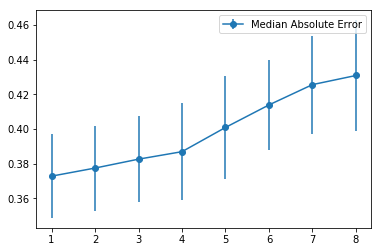

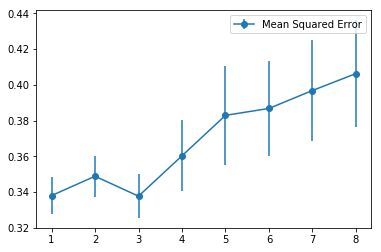

In [6]:
# visualize results

cvdf = cv_results_df  # code sugar

plt.figure()
plt.errorbar(cvdf.n_components, cvdf.mae__mean, cvdf.mae__std, marker='o', label='Median Absolute Error')
plt.legend()

plt.figure()
plt.errorbar(cvdf.n_components, cvdf.mse__mean, cvdf.mse__std, marker='o', label='Mean Squared Error')
plt.legend();

1 PC seems lik the best choice. More components and we are overfitting the training set.

# Modeling

This model will involve the whole dataset of Central Harlem schools, and with it, we will predict the gaps in schools.

In [15]:
inputs = df[[
    'Mean Scale Score - ELA',
    '% Level 2 - ELA',
    '% Level 3 - ELA',
    '% Level 4 - ELA',
    'Mean Scale Score - Math',
    '% Level 2 - Math',
    '% Level 3 - Math',
    '% Level 4 - Math',
]]
inputs = pd.DataFrame(PCA(1).fit_transform(inputs), index=inputs.index, columns=['PC1'])
inputs['Constant'] = 1

outputs = logit(df['% SHSAT Testers'])

In [16]:
# model

model = HuberRegressor(epsilon=1)  # strong robustness
model.fit(inputs, outputs)
predictions = model.predict(inputs)
residuals = outputs - predictions
pct_residuals = expit(outputs) - expit(predictions)

In [19]:
pivoted_residuals = residuals.reset_index().pivot(index='DBN', columns='Year', values='% SHSAT Testers')
pivoted_pct_residuals = pct_residuals.reset_index().pivot(index='DBN', columns='Year', values='% SHSAT Testers')

# Results

In [154]:
pivoted = pivoted_pct_residuals

/home/andre/miniconda3/envs/passnyc/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/andre/miniconda3/envs/passnyc/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/andre/miniconda3/envs/passnyc/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


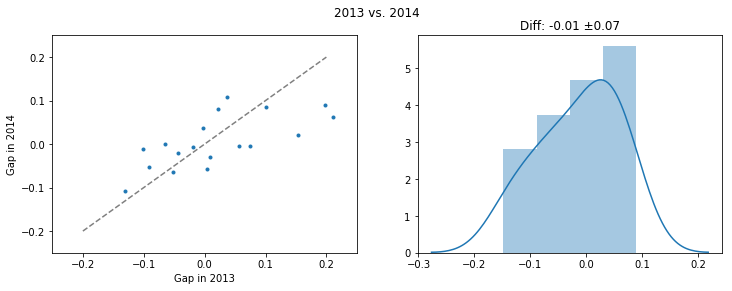

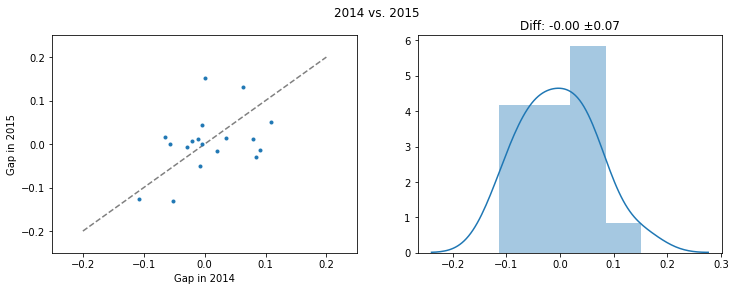

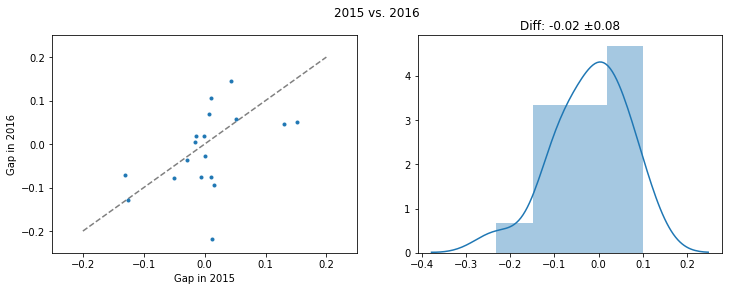

In [157]:
combinations = [
    (2013, 2014),
    (2014, 2015),
    (2015, 2016),
]

for y1, y2 in combinations:
    diffs = (pivoted[y2] - pivoted[y1]).dropna()
    mean = diffs.mean()
    std = diffs.std()
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))
    fig.suptitle("%s vs. %s" % (y1, y2))

    ax1.plot([-0.2, 0.2], [-0.2, 0.2], '--', color='gray')
    ax1.plot(pivoted[y1], pivoted[y2], '.')
    ax1.set_xlabel("Gap in %s" % y1)
    ax1.set_ylabel("Gap in %s" % y2)
    ax1.set_xlim(-0.25, 0.25)
    ax1.set_ylim(-0.25, 0.25)

    sns.distplot(diffs, ax=ax2)
    ax2.set_title("Diff: {:.2f} ±{:.2f}".format(mean, std))

In [160]:
df.loc['84M341']

,Charter School?,Number Tested - ELA,Mean Scale Score - ELA,# Level 1 - ELA,% Level 1 - ELA,# Level 2 - ELA,% Level 2 - ELA,# Level 3 - ELA,% Level 3 - ELA,# Level 4 - ELA,% Level 4 - ELA,# Level 3+4 - ELA,% Level 3+4 - ELA,Number Tested - Math,Mean Scale Score - Math,# Level 1 - Math,% Level 1 - Math,# Level 2 - Math,% Level 2 - Math,# Level 3 - Math,% Level 3 - Math,# Level 4 - Math,% Level 4 - Math,# Level 3+4 - Math,% Level 3+4 - Math,Enrollment on 10/31,# SHSAT Registrants,# SHSAT Testers,% SHSAT Registrants,% SHSAT Testers
Year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013,1.0,38.0,0.393883,9.0,23.684210,12.0,0.315790,16.0,0.421053,1.0,0.026316,17.0,44.73684,38.0,0.355142,9.0,23.684210,19.0,0.500000,7.0,0.184210,3.0,0.078947,10.0,26.31579,40,9,9,0.225000,0.225000
2014,1.0,77.0,0.185010,14.0,18.181820,42.0,0.545455,21.0,0.272727,0.0,0.000000,21.0,27.27273,76.0,0.511848,18.0,23.684210,29.0,0.381579,27.0,0.355263,2.0,0.026316,29.0,38.15789,76,27,20,0.355263,0.263158
2015,1.0,70.0,0.254101,14.0,20.000000,31.0,0.442857,23.0,0.328571,2.0,0.028571,25.0,35.71429,70.0,1.379765,5.0,7.142857,18.0,0.257143,24.0,0.342857,23.0,0.328571,47.0,67.14286,75,23,21,0.306667,0.280000
2016,1.0,79.0,0.637559,7.0,8.860759,38.0,0.481013,30.0,0.379747,4.0,0.050633,34.0,43.03797,79.0,1.385683,3.0,3.797468,11.0,0.139240,53.0,0.670886,12.0,0.151899,65.0,82.27848,79,10,5,0.126582,0.063291


---

We will assume that the gap in the year y takes the following value:

$G_y = G_{y-1} + \epsilon$

Where $\epsilon$ are iid error variables with std about 0.8

This kernel is hard... What we can affirm is that the gap of one is, yes, correlated to the gap of the next year. What we don't know exactly is how to express this correlation.

But, based on our finding, we can express them as a combination of the gap and a error term.

**What does this error term mean though?**

These are the anual oscillations that are expected inside a school (regarding the number of SHSAT applicants). So, let's say that in 2017, a school had a gap of about 17%. Next year, this schools is expected to have a gap of `17% ±8%`. I know, this is an approximation. But an approximation that works well and that goes well with our hypothesis.

My hyphotesis is that there is a standard percentage of applicants for each school. This standard may move with time, but overall, it moves slowly. So, what we really see are deviations of what is really happened for each school. And this is our gap.

So, everything is related a bit to what happened last year and to the baseline of each school. This baseline is what we have power on.

AR(1)  --  autorregression

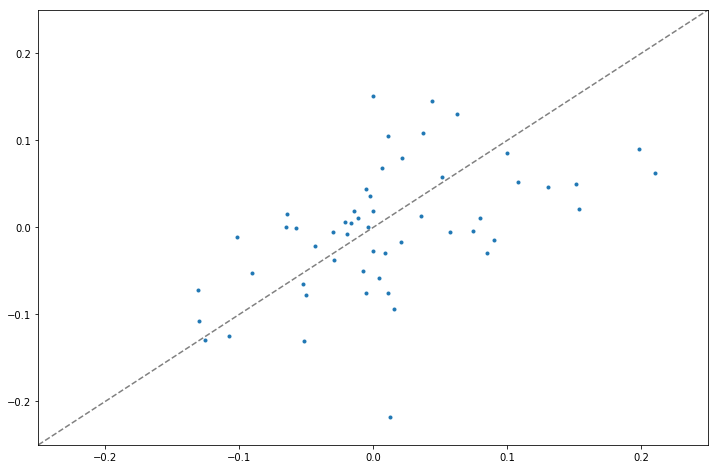

In [161]:
y1 = pd.concat([
    pivoted_pct_residuals[2013],
    pivoted_pct_residuals[2014],
    pivoted_pct_residuals[2015],    
]).reset_index(drop=True)
y1.name = "First Year"

y2 = pd.concat([
    pivoted_pct_residuals[2014],
    pivoted_pct_residuals[2015],
    pivoted_pct_residuals[2016],    
]).reset_index(drop=True)
y2.name = "Second Year"

plt.figure(figsize=(12, 8))
plt.plot(y1, y2, '.')
plt.plot([-0.25, 0.25], [-0.25, 0.25], '--', color='gray')
plt.xlim(-0.25, 0.25)
plt.ylim(-0.25, 0.25);

Model coefficient [0.45251995]
Model intercept -0.008025582863174372
Residuals std: 0.06337603055970167


/home/andre/miniconda3/envs/passnyc/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


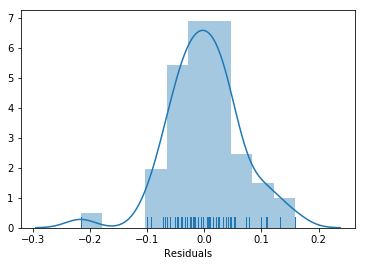

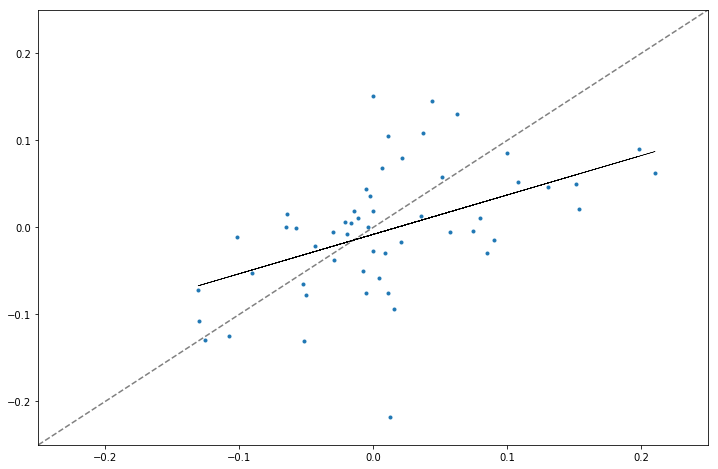

In [150]:
model = HuberRegressor()
model.fit(y1.to_frame(), y2)
y2_pred = model.predict(y1.to_frame())
resid = y2 - y2_pred
resid.name = 'Residuals'

print("Model coefficient", model.coef_)
print("Model intercept", model.intercept_)

plt.figure()
sns.distplot(resid, rug=True);

plt.figure(figsize=(12, 8))
plt.plot(y1, y2, '.')
plt.plot([-0.25, 0.25], [-0.25, 0.25], '--', color='gray')
plt.plot(y1, y2_pred, color='k', linewidth=0.5)
plt.xlim(-0.25, 0.25)
plt.ylim(-0.25, 0.25)

print("Residuals std:", resid.std())

---

In [166]:
ppr = pivoted_pct_residuals.copy()
ppr.head()

Year,2013,2014,2015,2016
DBN,,,,
05M046,0.004541,-0.057705,-0.000511,0.018310
05M123,0.100203,0.084982,-0.029470,-0.037573
05M129,0.021284,0.079650,0.010923,0.105606
05M161,-0.101374,-0.011623,0.010969,-0.075585
05M286,0.056996,-0.005051,0.044053,0.145293


In [167]:
ppr.std()

Year
2013    0.098700
2014    0.060257
2015    0.069355
2016    0.090371
dtype: float64

In [87]:
"""
Partial Correlation in Python
 
Based on Fabian Pedregosa-Izquierdo's implementation at:
https://gist.github.com/fabianp/9396204419c7b638d38f
 
This version of the algorithm calculates the partial correlation coefficient controlling for Z.
I use row vectors here, for whatever reason.
"""
 
import numpy as np 
 
def partial_corr(X,Z):
    """
    Returns the partial correlation coefficients between elements of X controlling for the elements in Z.
    """
    
    X = np.asarray(X)
    Z = np.asarray(Z)
    n = X.shape[1]
 
    partial_corr = np.zeros((n,n), dtype=np.float)
    for i in range(n):
        partial_corr[i,i] = 1
        for j in range(i+1,n):
            beta_i = np.linalg.lstsq(Z, X[:,j])[0]
            beta_j = np.linalg.lstsq(Z, X[:,i])[0]
 
            res_j = X[:,j] - Z.dot(beta_i)
            res_i = X[:,i] - Z.dot(beta_j)
 
            corr = np.corrcoef(res_i,res_j)
 
            partial_corr[i,j] = corr.item(0,1)
            partial_corr[j,i] = corr.item(0,1)
 
    return partial_corr[0][1]

In [88]:
# corr1
y1 = pd.concat([ppr[2013], ppr[2014], ppr[2015]])
y2 = pd.concat([ppr[2014], ppr[2015], ppr[2016]])
ys = pd.concat([y1, y2], axis=1)
nullz = np.zeros(ys.shape)
corr1 = partial_corr(ys, nullz)

# corr2
y1 = pd.concat([ppr[2013], ppr[2014]])
y2 = pd.concat([ppr[2015], ppr[2016]])
ys = pd.concat([y1, y2], axis=1)
nullz = np.zeros(ys.shape)
corr2 = partial_corr(ys, nullz)

# corr3
y1 = pd.concat([ppr[2013]])
y2 = pd.concat([ppr[2016]])
ys = pd.concat([y1, y2], axis=1)
nullz = np.zeros(ys.shape)
corr3 = partial_corr(ys, nullz)



# pcorr1
y1 = pd.concat([ppr[2013], ppr[2014], ppr[2015]])
y2 = pd.concat([ppr[2014], ppr[2015], ppr[2016]])
ys = pd.concat([y1, y2], axis=1)
nullz = np.zeros(ys.shape)
pcorr1 = partial_corr(ys, nullz)

# pcorr2
y1 = pd.concat([ppr[2013], ppr[2014]])
y2 = pd.concat([ppr[2015], ppr[2016]])
ys = pd.concat([y1, y2], axis=1)
zs = pd.concat([ppr[2014], ppr[2015]]).to_frame()
nullz = np.zeros(ys.shape)
pcorr2 = partial_corr(ys, zs)

# corr3
y1 = pd.concat([ppr[2013]])
y2 = pd.concat([ppr[2016]])
ys = pd.concat([y1, y2], axis=1)
zs = ppr[[2014, 2015]]
pcorr3 = partial_corr(ys, zs)

/home/andre/miniconda3/envs/passnyc/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/andre/miniconda3/envs/passnyc/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


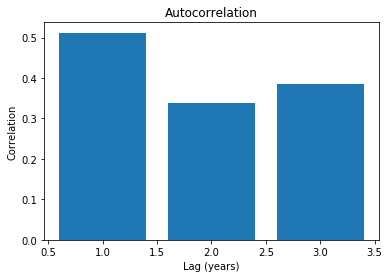

In [89]:
plt.bar([1, 2, 3], [corr1, corr2, corr3])
plt.xlabel('Lag (years)')
plt.ylabel('Correlation')
plt.title('Autocorrelation');

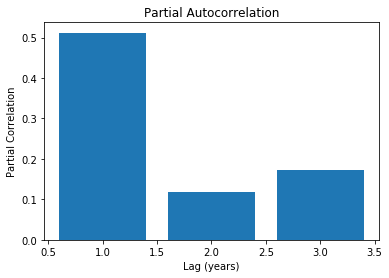

In [90]:
plt.bar([1, 2, 3], [pcorr1, pcorr2, pcorr3])
plt.xlabel('Lag (years)')
plt.ylabel('Partial Correlation')
plt.title('Partial Autocorrelation');

This indicates the effect of one year onto the next is big, but the effect of one year two years later (partial) is negligible (equivalent to the effect after two years. This may be an AR(1) model.

In [91]:
ppr.corr()

Year,2013,2014,2015,2016
Year,,,,
2013,1.000000,0.685449,0.340699,0.384402
2014,0.685449,1.000000,0.422088,0.374683
2015,0.340699,0.422088,1.000000,0.480540
2016,0.384402,0.374683,0.480540,1.000000


The first correelation is way big. This indicates a simple linear model will suffice. (more study is needed though)

---

In [183]:
d = ppr.copy()  # gaps per year

targets = d[2016]
inputs = pd.DataFrame({
    'baseline': d.loc[:, :2015].apply(np.mean, axis=1),
    '2015': d[2015]
})

model = sm.RLM(targets, inputs)
results = model.fit()
predictions = model.predict(params=results.params)
residuals = targets - predictions

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                   2016   No. Observations:                   18
Model:                            RLM   Df Residuals:                       16
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 06 Aug 2018                                         
Time:                        15:07:00                                         
No. Iterations:                     9                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
baseline       0.4184      0.372      1.124      0.261      -0.311       1.148
2015           0.3621      0.337      1.075      0.282      -0.298       1.022
==============================================================================

If the model instance has been used for another fit with different fit
parameters, then the fit options might not be the correct ones anymore .
"""

In [184]:
residuals.std()

0.07630214174557653

---

Normal play

how many standard deviations above give probability of being higher?

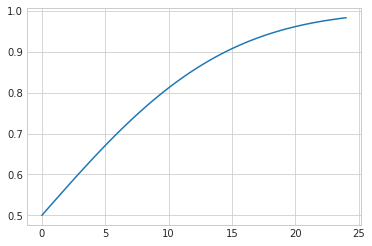

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import norm

sns.set_style('whitegrid')

cdf = norm.cdf
prob = lambda x: cdf(x / np.sqrt(2))

xs = np.linspace(0, 3, 100)
ys = prob(xs)

xs = xs * 8  # 8 pct s.d.
plt.plot(xs, ys)

In [6]:
for gap_diff in [1, 3, 8, 15, 25]:
    print(gap_diff, prob(gap_diff / 8))

1 0.5352159888611936
3 0.604558838529688
8 0.7602499389065233
15 0.9075512005171998
25 0.9864373069104667
